<a href="https://colab.research.google.com/github/bks1984/CRAFT-pytorch/blob/master/stock_market__news_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://images.pexels.com/photos/159888/pexels-photo-159888.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" width="480"/>
</p></center>

<center><font size=5>Stock Market News Sentiment Analysis</center></font>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To build, tune, and evaluate ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# Import TensorFlow and Keras for deep learning model building.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the Dataset**

In [ ]:
# # uncomment and run the following code if Google Colab is being used and the dataset is in Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Read the CSV file named 'stock_news' into a pandas DataFrame named 'stock'
stock_news = pd.read_csv("/content/02. Dataset - stock_news.csv")

In [ ]:
#Creating a copy of the dataset
stock = stock_news.copy()

## **Data Overview**

#### **Displaying the first few rows of the dataset**

In [ ]:
stock.head(5)

,Date,News,Open,High,Low,Close,Volume,Label
0,01-02-2019,The dollar minutes ago tumbled to 106 67 from...,38.72,39.71,38.56,39.48,130672400,1
1,01-02-2019,By Wayne Cole and Swati Pandey SYDNEY Reuters...,38.72,39.71,38.56,39.48,130672400,-1
2,01-02-2019,By Stephen Culp NEW YORK Reuters Wall Stre...,38.72,39.71,38.56,39.48,130672400,0
3,01-02-2019,By Wayne Cole SYDNEY Reuters The Australia...,38.72,39.71,38.56,39.48,130672400,-1
4,01-02-2019,Investing com Asian equities fell in morning...,38.72,39.71,38.56,39.48,130672400,1


#### **Understanding the shape of the dataset**

In [ ]:
stock.shape

(418, 8)

**Observations:**
* There are a total of 418 records with 8 attributes each.

#### **Checking the data types of the columns**

In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    418 non-null    object 
 1   News    418 non-null    object 
 2   Open    418 non-null    float64
 3   High    418 non-null    float64
 4   Low     418 non-null    float64
 5   Close   418 non-null    float64
 6   Volume  418 non-null    int64  
 7   Label   418 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 26.3+ KB


Let's convert the Date column to pandas `datetime` type.

In [ ]:
# Convert the 'Date' column in the 'stocks' DataFrame to datetime format
stock['Date'] = pd.to_datetime(stock['Date'])

#### **Checking the statistical summary**

In [ ]:
stock.describe()

,Date,Open,High,Low,Close,Volume,Label
count,418,418.000000,418.000000,418.000000,418.000000,4.180000e+02,418.000000
mean,2019-02-14 12:24:06.889952256,42.308852,42.787321,41.923732,42.418517,1.294225e+08,0.308612
min,2019-01-02 00:00:00,35.990000,36.430000,35.500000,35.550000,4.544800e+07,-1.000000
25%,2019-01-11 00:00:00,38.130000,38.420000,37.720000,38.270000,1.029072e+08,-1.000000
50%,2019-01-31 00:00:00,41.530000,42.250000,41.140000,41.610000,1.156272e+08,1.000000
75%,2019-03-21 00:00:00,47.190000,47.427500,46.480000,47.032500,1.511252e+08,1.000000
max,2019-04-29 00:00:00,51.840000,52.120000,51.760000,51.870000,3.652488e+08,1.000000
std,NaN,4.947134,4.947413,4.967880,4.999867,4.574550e+07,0.943473


**Observations:**

- **Date Range and Trading Period**:
  - The data covers a period from January 2, 2019, to April 29, 2019, indicating a span of approximately four months.

- **Price Overview**:
  - **Average Prices**: The average opening price is approximately \$42.30, while the average closing price is about \$42.41.
  - **Price Variability**: The prices range from a minimum of around \$35.99 for opening to a maximum of \$51.84 for opening, reflecting significant volatility during this period.

- **Trading Volume**:
  - The average trading volume is approximately 129.42 million shares, with fluctuations from around 45.45 million to 365.24 million, highlighting varying market activity levels.

#### **Checking the duplicate values**

In [ ]:
stock.duplicated().sum()

0

**Observations:**
* There are no duplicate values.

#### **Checking for missing values**

In [ ]:
stock.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


**Observations:**
* There are no missing values.

## **Exploratory Data Analysis**

### **Univariate Analysis**

#### **Countplot on Label**

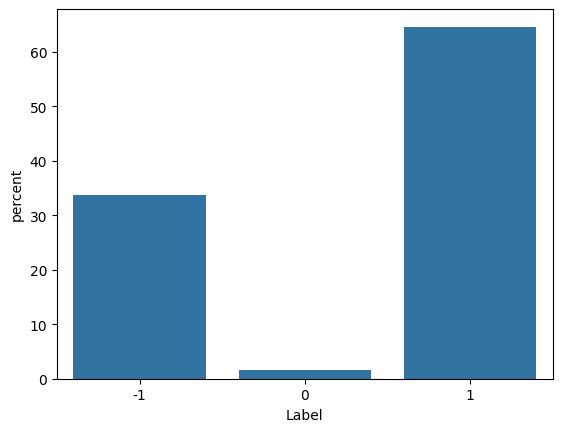

In [ ]:
sns.countplot(data=stock, x='Label', stat="percent");

**Observations:**
* The dataset is imbalanced for the sentiment polarities.
* There is more news content with positive polarity compared to other types.

#### **Density Plot of Price (Open, High, Low, Close)**

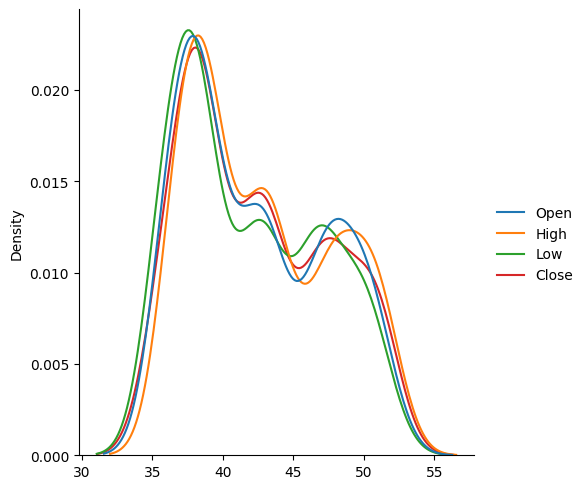

In [ ]:
# Plot KDE for the 'Open', 'High', 'Low', 'Close' columns of the 'stock' DataFrame.
sns.displot(data=stock[['Open','High','Low','Close']], kind='kde', palette="tab10");  # Create a KDE plot with a color palette.

**Observations:**
* The distributions of the prices are quite similar, with the high price showing a slight variation than the others.

#### **Histogram on Volume**

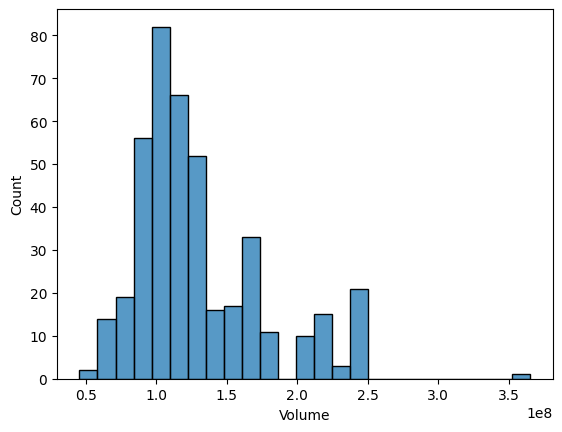

In [ ]:
sns.histplot(stock, x='Volume');

**Observations:**
* In a large portion of the time considered, 80 to 175 million shares of the stock were traded, with occasional days where the volume rose to more than 200 million.

#### **Histogram and statistical summary on News Length**

In [ ]:
#Calculating the total number of words present in the news content.
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))
stock['news_len'].describe()

,news_len
count,418.000000
mean,525.662679
std,303.584080
min,44.000000
25%,304.250000
50%,480.000000
75%,700.500000
max,2142.000000


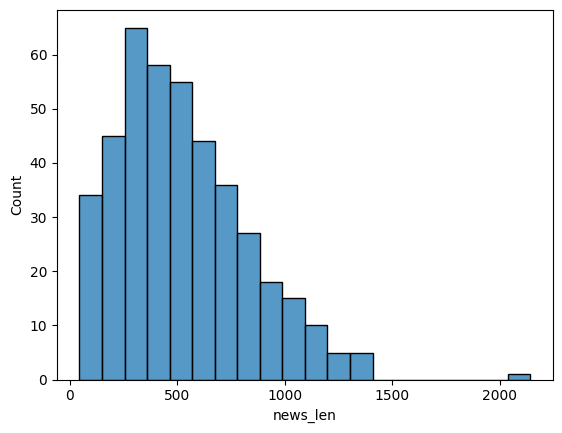

In [ ]:
sns.histplot(data=stock,x='news_len');

**Observations:**
* Most of the news have between 50 - 1000 words, with an average of 525 words
    * The shortest news has 44 words

* This indicates that these are likely to be news summaries rather than the actual news content itself.

### **Bivariate Analysis**

#### **Correlation**

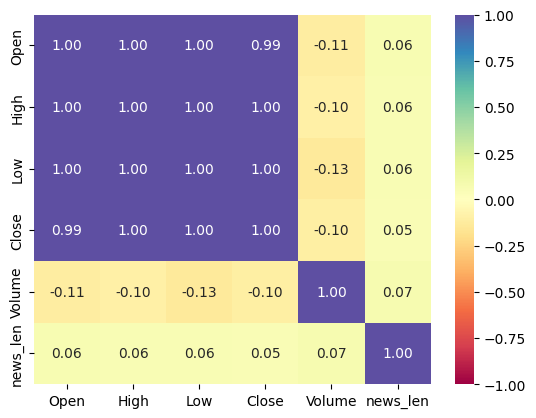

In [ ]:
cols = ['Open','High','Low','Close','Volume','news_len']
sns.heatmap(
    stock[cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

**Observations:**
* The prices are all perfectly correlated.
    * This might be due to the minimum variation between the different prices.

* There is a negative correlation, albeit very low, between volume and prices.
    * This might be due to selling pressure during periods of negative sentiment.

#### **Label vs Price (Open, High, Low, Close)**

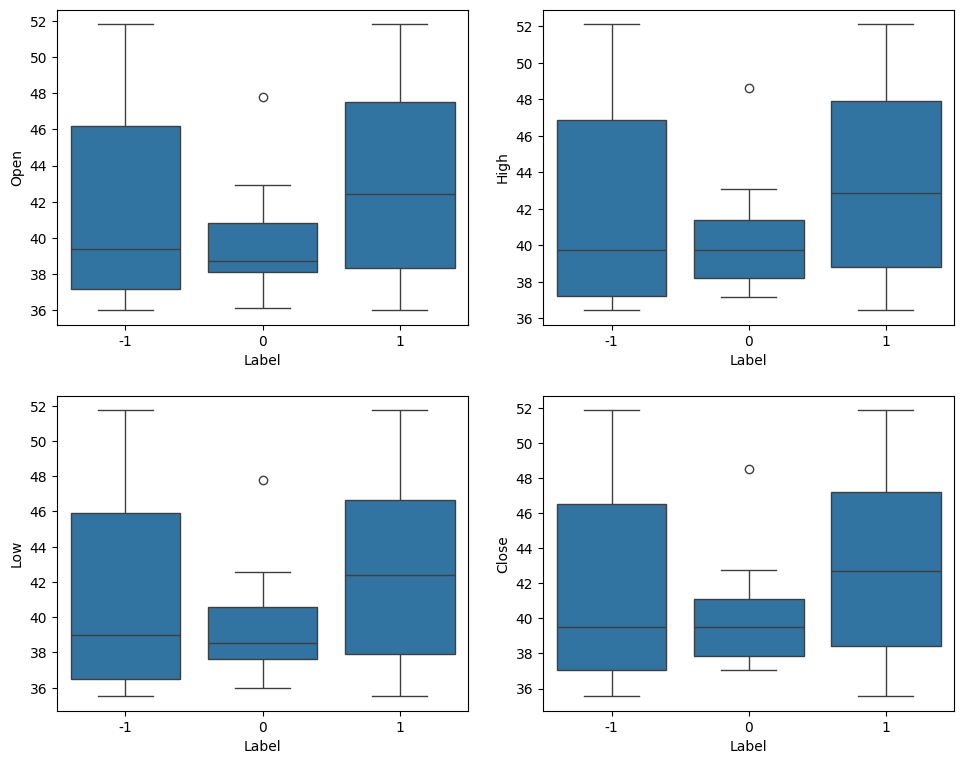

In [ ]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

**Observations:**
* The median for all prices is significantly lower for negative sentiment news as compared to both positive and neutral sentiment news, indicating that negative news likely triggers investor sell-offs which drive the stock prices down.

* The boxplot for the open price under neutral sentiment displays a notably higher upper whisker relative to positive sentiment. This suggests that the market's opening often covers a wider range of prices when news is neutral.
    * This variability might be attributed to different interpretations of seemingly neutral news, which leads some investors to react more aggressively and drive the opening price to higher levels.

#### **Label vs Volume**

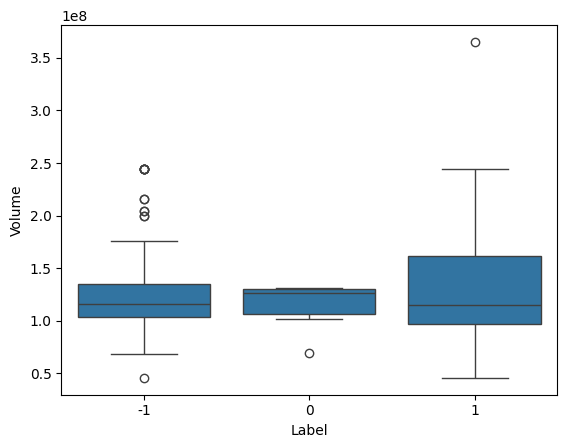

In [ ]:
sns.boxplot(
    data=stock, x="Label", y="Volume"
);

**Observations:**
* The median trading volume for the stock is approximately the same across all sentiment polarities.
* The volume distribution for positive sentiment news shows a wider spread compared to other sentiment categories.
  - This wider range might indicate that even positive news leads to diverse interpretations among investors, contributing to varied trading activities and reactions.

#### **Date vs Price (Open, High, Low, Close)**

- The data is at the level of news, and we might have more than one news in a day. However, the prices are at daily level
- So, we can aggregate the data at a daily level by taking the mean of the attributes

In [ ]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,38.72,39.71,38.56,39.48,130672400.0
2019-01-03,35.99,36.43,35.50,35.55,103544800.0
2019-01-04,36.13,37.14,35.95,37.06,111448000.0
2019-01-07,37.17,37.21,36.47,36.98,109012000.0
2019-01-08,37.39,37.96,37.13,37.69,216071600.0


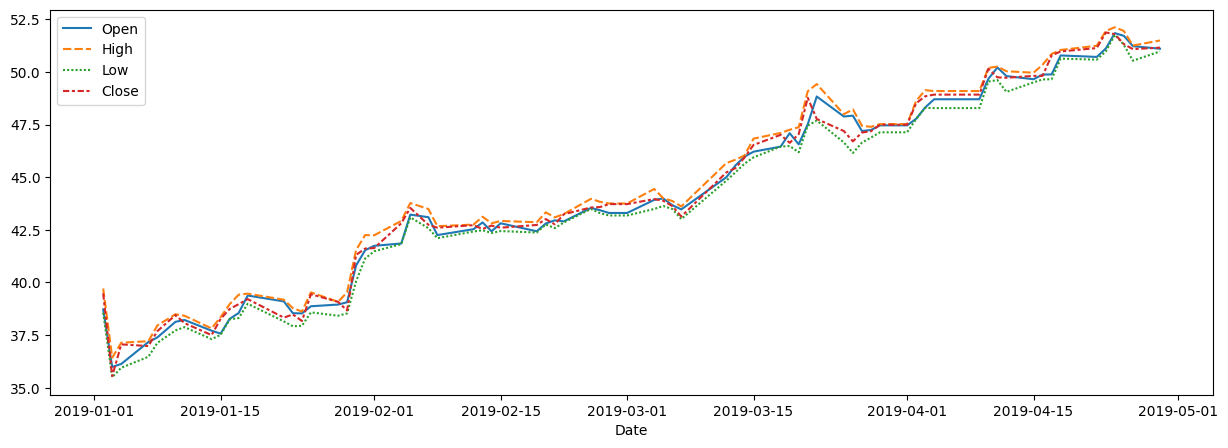

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop('Volume', axis=1));

**Observations:**
* The stock price has gradually increased over time from ~\$40 to ~\$50 in the period for which the data is available.

#### **Volume vs Close Price**

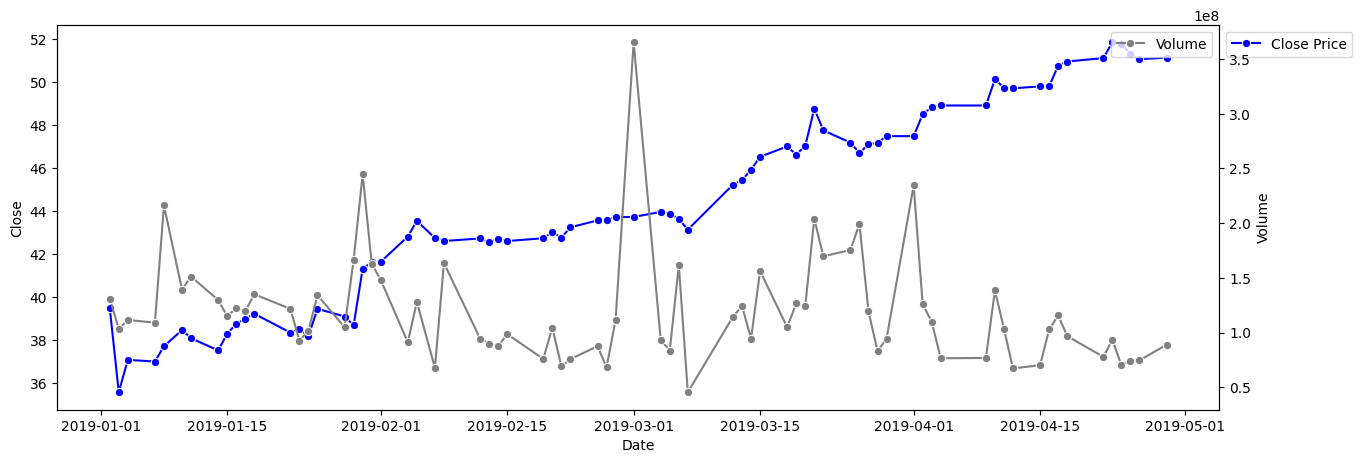

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

**Observations:**
- There is no specific pattern here
    - There have been periods where the price decreased with increasing volumes
    - There have been periods where the price increased with increasing volumes

## **Data Preprocessing**

In [ ]:
stock['Date'].describe()

,Date
count,418
mean,2019-02-14 12:24:06.889952256
min,2019-01-02 00:00:00
25%,2019-01-11 00:00:00
50%,2019-01-31 00:00:00
75%,2019-03-21 00:00:00
max,2019-04-29 00:00:00


**Observations:**
* We see that 75% of the data is till the third week of March 2019.
* We'll take the data till the end of March 2019 for training, and keep the April 2019 data for test set.

### Train-test Split

In [ ]:
X_train = stock[stock['Date'] < '2019-04-01'].reset_index()
X_test = stock[(stock['Date'] >= '2019-04-01')].reset_index()

In [ ]:
y_train = X_train['Label'].copy()
y_test = X_test['Label'].copy()

In [ ]:
print("Train data shape",X_train.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Test label shape ",y_test.shape)

Train data shape (347, 10)
Test data shape  (71, 10)
Train label shape (347,)
Test label shape  (71,)


In [ ]:
# y_train.value_counts(normalize=True)

In [ ]:
# y_test.value_counts(normalize=True)

## **Word Embeddings**

### **Generating Text Embeddings using Word2Vec**

#### **Defining the model**

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['News'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 14577


#### **Encoding the datasets**

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

#### **Averaging the word vectors to get sentence encodings**

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  8.816098928451538


In [ ]:
print(X_train_wv.shape, X_test_wv.shape)

(347, 300) (71, 300)


### **Generating Text Embeddings using Sentence Transformer**

#### **Defining the model**

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#### **Encoding the dataset**

In [ ]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train['News'].values, show_progress_bar=True, device="cpu")
X_test_st = model.encode(X_test['News'].values, show_progress_bar=True, device="cpu")

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Time taken  54.070236682891846


In [ ]:
print(X_train_st.shape, X_test_st.shape)

(347, 384) (71, 384)


- Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### **Defining Model Evaluation Criterion**

- In stock analysis, where the accuracy of classifying news into positive, negative, or neutral categories directly impacts decision-making, the **F1 Score** is the best metric.
- It balances precision and recall, which helps ensure that your model is both accurate and comprehensive. Precision minimizes false positives, so you don’t overreact to neutral news as negative, while recall ensures you capture all relevant news, avoiding missed risks.
- This balance is crucial, especially when the news distribution may be imbalanced, helping you make better-informed stock decisions.

##### **Defining Utility Functions**

In [ ]:
def plot_confusion_matrix(Actual, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    # Define the labels for the confusion matrix
    label_list = [-1, 0, 1]

    # Compute the confusion matrix.
    cm = confusion_matrix(Actual, target, labels=label_list)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [ ]:
def model_performance_classification_sklearn(actual, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    actual (array-like): The true labels.
    target (array-like): The predicted labels.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual, target)
    # Compute Recall
    recall = recall_score(actual, target,average='weighted')
    # Compute Precision
    precision = precision_score(actual, target,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual, target,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

### **Building Random Forest Models using different text embeddings**

#### **Building a Random Forest Model using text embeddings obtained from the Word2Vec**

In [ ]:
# Building the model
rf_word2vec = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 42)


# Fitting on train data
rf_word2vec.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

#### **Checking Training and Test Performance**


In [ ]:
# Predicting on train data
y_pred_train = rf_word2vec.predict(X_train_wv)

# Predicting on test data
y_pred_test = rf_word2vec.predict(X_test_wv)

**Confusion Matrix**

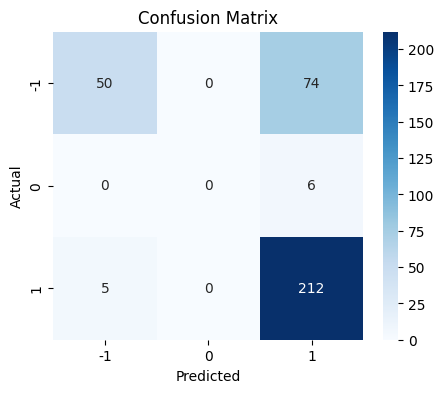

In [ ]:
plot_confusion_matrix(y_train,y_pred_train)

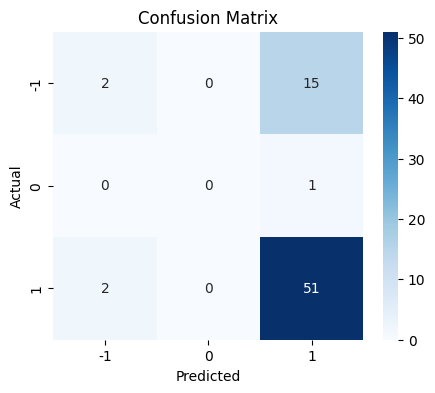

In [ ]:
plot_confusion_matrix(y_test,y_pred_test)

**Classification Report**

In [ ]:
#Calculating different metrics on training data
rf_train_wv = model_performance_classification_sklearn(y_train,y_pred_train)
print("Training performance:\n", rf_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.755043  0.755043   0.778891  0.720565


In [ ]:
#Calculating different metrics on test data
rf_test_wv = model_performance_classification_sklearn(y_test, y_pred_test)
print("Testing performance:\n",rf_test_wv)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.746479  0.746479   0.687934  0.680114


* The model is slightly overfitting, as there is a little difference between its performance on the training set and the test set.

#### **Building a Random Forest Model using text embeddings obtained from the Sentence Transformer**

In [ ]:
# Building the model
rf_st = RandomForestClassifier(n_estimators = 100, max_depth = 3, random_state = 42)


# Fitting on train data
rf_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

#### **Checking Training and Test Performance**

In [ ]:
# Predicting on train data
y_pred_train = rf_st.predict(X_train_st)

# Predicting on test data
y_pred_test = rf_st.predict(X_test_st)

**Confusion Matrix**

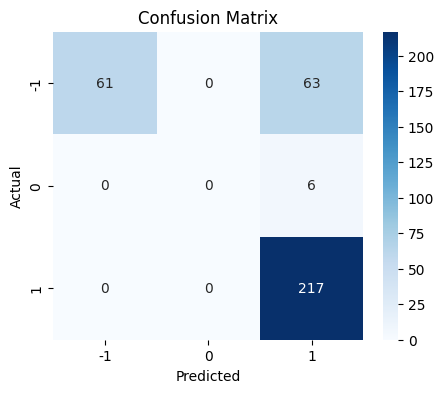

In [ ]:
plot_confusion_matrix(y_train,y_pred_train)

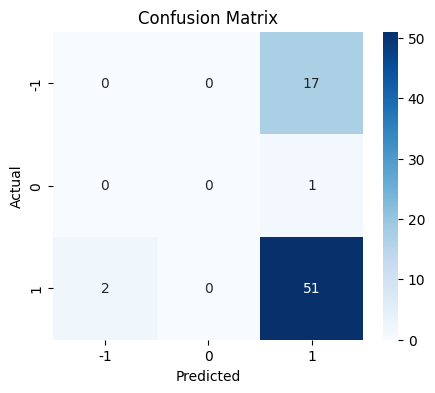

In [ ]:
plot_confusion_matrix(y_test,y_pred_test)

**Classification Report**

In [ ]:
#Calculating different metrics on training data
rf_train_st = model_performance_classification_sklearn(y_train,y_pred_train)
print("Training performance:\n", rf_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.801153  0.801153   0.831835  0.775232


In [ ]:
#Calculating different metrics on test data
rf_test_st = model_performance_classification_sklearn(y_test, y_pred_test)
print("Testing performance:\n",rf_test_st)

Testing performance:
    Accuracy   Recall  Precision        F1
0   0.71831  0.71831   0.551745  0.624105


* The model is highly overfitting, as there is a significant difference between its performance on the training set and the test set.

### **Building Neural Network Models using different text embeddings**

#### **Building a Neural Network Model using text embeddings obtained from the Word2Vec**

In [ ]:
# Convert the labels
label_mapping = {1: 2, -1: 0, 0: 1}
y_train_mapped_wv = [label_mapping[label] for label in y_train]
y_test_mapped_wv = [label_mapping[label] for label in y_test]

# Convert your features DataFrame to a NumPy array
X_train_wv_np = np.array(X_train_wv)
X_test_wv_np = np.array(X_test_wv)
y_train_mapped_wv = np.array(y_train_mapped_wv)
y_test_mapped_wv = np.array(y_test_mapped_wv)

In [ ]:
import gc

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_wv_np.shape[1],))) # Use the shape of the Word2Vec embeddings
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics =['accuracy'])

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,979 (183.51 KB)

 Trainable params: 46,979 (183.51 KB)

 Non-trainable params: 0 (0.00 B)

**Note:**
- During training, we use accuracy as a metric to monitor how well the model is learning to distinguish between classes in each batch.
- Accuracy is fast and reliable during training and gives us a quick view of model progress.
- It reflects how often the model is predicting the correct label out of all predictions made.



In [ ]:
# Fitting the model
history = model.fit(
    X_train_wv_np, y_train_mapped_wv,
    epochs=10,
    batch_size=32
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5349 - loss: 0.9062
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6190 - loss: 0.7523 
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5989 - loss: 0.7214 
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5874 - loss: 0.7687 
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6741 - loss: 0.7038 
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6298 - loss: 0.7276 
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6655 - loss: 0.7134 
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6025 - loss: 0.7213 
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6321 - loss: 0.7183 
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6456 - loss: 0.7322 


#### **Checking Training and Test Performance**

In [ ]:
# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train_wv_np)

# Convert probabilities to class labels
y_train_preds_wv = tf.argmax(y_train_pred_probs, axis=1).numpy()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test_wv_np)

# Convert probabilities to class labels
y_test_preds_wv = tf.argmax(y_test_pred_probs, axis=1).numpy()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
# Convert back to [-1, 0, 1] to match utility function expectations
label_mapping = {2: 1, 0: -1, 1: 0}
y_train_preds_wv = np.array([label_mapping[index] for index in y_train_preds_wv])
y_test_preds_wv = np.array([label_mapping[index] for index in y_test_preds_wv])

**Confusion Matrix**

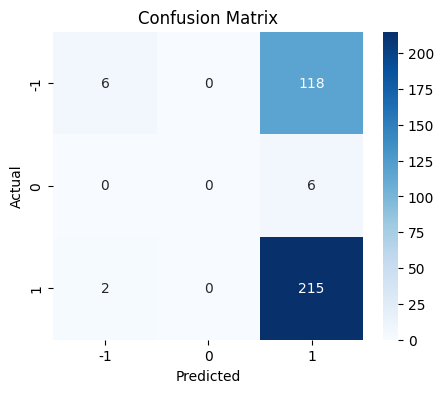

In [ ]:
plot_confusion_matrix(y_train, y_train_preds_wv)

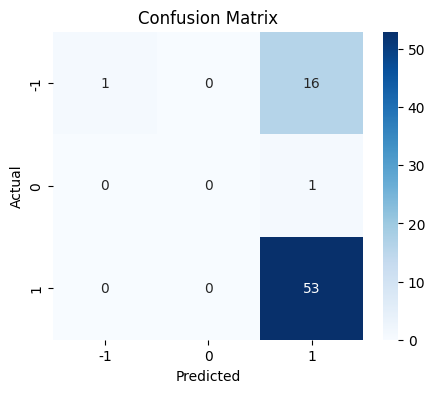

In [ ]:
plot_confusion_matrix(y_test, y_test_preds_wv)

**Classification Report**

In [ ]:
#Calculating different metrics on training data
NN_train_wv = model_performance_classification_sklearn(y_train,y_train_preds_wv)
print("Training performance:\n", NN_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.636888  0.636888   0.664626  0.516128


In [ ]:
#Calculating different metrics on test data
NN_test_wv = model_performance_classification_sklearn(y_test, y_test_preds_wv)
print("Testing performance:\n",NN_test_wv)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.760563  0.760563   0.804628  0.669911


#### **Building a Neural Network Model using text embeddings obtained from the Sentence Transformer**

In [ ]:
# Convert the labels
label_mapping = {1: 2, -1: 0, 0: 1}
y_train_mapped_st = [label_mapping[label] for label in y_train]
y_test_mapped_st = [label_mapping[label] for label in y_test]

# Convert your features DataFrame to a NumPy array
X_train_st_np = np.array(X_train_st)
X_test_st_np = np.array(X_test_st)
y_train_mapped_st = np.array(y_train_mapped_st)
y_test_mapped_st = np.array(y_test_mapped_st)

In [ ]:
import gc

# Clear previous sessions
tf.keras.backend.clear_session()
gc.collect()

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_st.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes (positive, negative, neutral)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['Accuracy'])

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the model
history = model.fit(
    X_train_st_np, y_train_mapped_st,
    epochs=15,
    batch_size=32
)

Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Accuracy: 0.6300 - loss: 1.0422
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.6496 - loss: 0.8380 
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.6464 - loss: 0.7074 
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.6099 - loss: 0.7004 
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.6664 - loss: 0.6625 
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.6915 - loss: 0.6035 
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.7356 - loss: 0.5585 
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.7714 - loss: 0.5521 
Epoch 9/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Accuracy: 0.7655 - loss: 0.5158 
Epoch 10/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Accuracy: 0.7861 - loss: 0.4997 
Epoch 11/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Accuracy: 0.8121 - loss: 0.4551
Epoch 12/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Accuracy: 0

#### **Checking Training and Test Performance**

In [ ]:
# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train_st_np)

# Convert probabilities to class labels
y_train_preds_st = tf.argmax(y_train_pred_probs, axis=1).numpy()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test_st_np)

# Convert probabilities to class labels
y_test_preds_st = tf.argmax(y_test_pred_probs, axis=1).numpy()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
# Convert back to [-1, 0, 1] to match utility function expectations
label_mapping = {2: 1, 0: -1, 1: 0}
y_train_preds_st = np.array([label_mapping[index] for index in y_train_preds_st])
y_test_preds_st = np.array([label_mapping[index] for index in y_test_preds_st])

**Confusion Matrix**

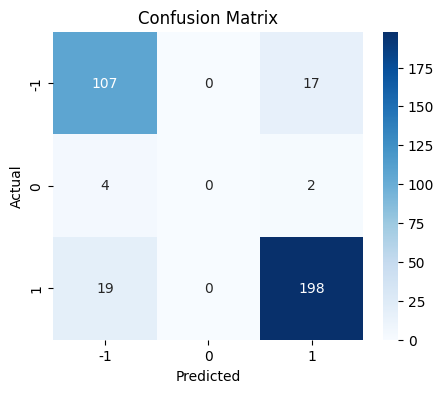

In [ ]:
plot_confusion_matrix(y_train, y_train_preds_st)

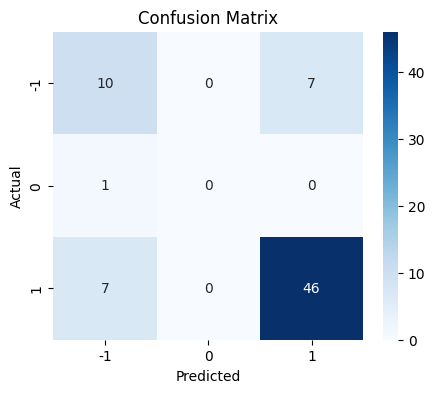

In [ ]:
plot_confusion_matrix(y_test, y_test_preds_st)

**Classification Report**

In [ ]:
#Calculating different metrics on training data
NN_train_st = model_performance_classification_sklearn(y_train,y_train_preds_st)
print("Training performance:\n", NN_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.878963  0.878963   0.864731  0.871679


In [ ]:
#Calculating different metrics on test data
NN_test_st = model_performance_classification_sklearn(y_test, y_test_preds_st)
print("Testing performance:\n",NN_test_st)

Testing performance:
    Accuracy    Recall  Precision        F1
0  0.788732  0.788732   0.780908  0.784708


### **Model Performance Summary and Final Model Selection**

In [ ]:
# Concatenate the training performance metrics from different models into a single DataFrame
models_train_comp_df = pd.concat(
    [
        rf_train_wv.T,  # Random Forest using Word2Vec embeddings
        NN_train_wv.T,  # Neural Network using Word2Vec embeddings
        rf_train_st.T,  # Random Forest using Sentence Transformer embeddings
        NN_train_st.T   # Neural Network using Sentence Transformer embeddings
    ],
    axis=1  # Concatenate along columns (i.e., each model's metrics form one column)
)

# Assigning meaningful column names for each model for clarity in the output DataFrame
models_train_comp_df.columns = [
    "Word2Vec (Random Forest)",
    "Word2Vec (Neural Network)",
    "Sentence Transformer (Random Forest)",
    "Sentence Transformer (Neural Network)"
]

# Print the training performance comparison table
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Word2Vec (Random Forest),Word2Vec (Neural Network),Sentence Transformer (Random Forest),Sentence Transformer (Neural Network)
Accuracy,0.755043,0.636888,0.801153,0.878963
Recall,0.755043,0.636888,0.801153,0.878963
Precision,0.778891,0.664626,0.831835,0.864731
F1,0.720565,0.516128,0.775232,0.871679


In [ ]:
# Concatenate the testing performance metrics from different models into a single DataFrame
models_test_comp_df = pd.concat(
    [
        rf_test_wv.T,  # Random Forest using Word2Vec embeddings
        NN_test_wv.T,  # Neural Network using Word2Vec embeddings
        rf_test_st.T,  # Random Forest using Sentence Transformer embeddings
        NN_test_st.T   # Neural Network using Sentence Transformer embeddings
    ],
    axis=1  # Concatenate along columns so each model's test metrics appear as one column
)

# Set descriptive column names for clarity in the resulting comparison table
models_test_comp_df.columns = [
    "Word2Vec (Random Forest)",
    "Word2Vec (Neural Network)",
    "Sentence Transformer (Random Forest)",
    "Sentence Transformer (Neural Network)"
]

# Print the testing performance comparison table
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Word2Vec (Random Forest),Word2Vec (Neural Network),Sentence Transformer (Random Forest),Sentence Transformer (Neural Network)
Accuracy,0.746479,0.760563,0.718310,0.788732
Recall,0.746479,0.760563,0.718310,0.788732
Precision,0.687934,0.804628,0.551745,0.780908
F1,0.680114,0.669911,0.624105,0.784708


#### **Model Performance Summary:**

<font size=5> **Model Selection: Sentence Transformer + Neural Network**</font>

**Rationale:**

1. **Best Generalization**:
   The Sentence Transformer + Neural Network model achieves the highest F1 score on the test set (0.788), indicating strong generalization and better handling of both precision and recall on unseen data.

2. **Balanced Performance**:
   Training F1 = 0.87 and testing F1 = 0.78 show a minimal gap, meaning the model learned meaningful representations without significant overfitting.

3. **Superior Feature Encoding**:
   Sentence Transformers capture semantic meaning more effectively than Word2Vec, which explains the performance boost across both Random Forest and Neural Network setups.

4. **Neural Network Suitability**:
   While Word2Vec + NN struggles due to sparse and less informative vectors, combining powerful embeddings (Sentence Transformer) with flexible learning (NN) achieves the best synergy.

##### **Why Other Models Were Not Chosen?**

* **Word2Vec + RF**:
   Training F1 = 0.730, Test F1 = 0.685. Although the gap is small (shows some stability), the absolute test performance is lower than Sentence Transformer + NN.

* **Word2Vec + NN**:
   Low performance in both training (F1 = 0.516) and testing (F1 = 0.67) indicates underfitting and ineffective learning due to weak input representations.

* **Sentence Transformer + RF**:
   Strong training F1 = 0.775, but test F1 = 0.624 is slightly lower than the NN version, suggesting mild overfitting and less flexibility in modeling complex patterns.

## **Conclusions and Recommendations**

* The daily opening, high, low, and closing prices of the stock exhibit similar distributions individually, when compared across different sentiment polarities, and negative sentiment news resulted in a lower value for each price.

* The minimum variation also resulted in the prices exhibiting perfect correlation amongst them, while exhibiting a very low negative correlation with volume, which might be due to selling pressure during periods of negative sentiment.

* The stock price gradually increased over time from ~40 to ~50 in the period for which the data is available while exhibiting a monthly trend.

* We predicted the sentiment of market news by encoding them via different ML models.

* The models largely overfit the data, with only **the Sentence Transformer + Neural Network model** yielding comparatively better performance than the others (train F1 = 0.876, test F1 = 0.788).

  * The predominance of neutral news also suggests a cautious market sentiment in this period. As such, a wider period should be considered for data collection to ensure volume and diversity in news sentiment polarities.

* Integrating real-time sentiment analysis systems can allow financial analysts to make informed decisions and quickly respond to market sentiment changes to optimize investment strategies.

* One can explore combining news sentiments with technical and fundamental indicators of the stock and introduce data of other similar stocks for a more comprehensive market analysis.

<font size = 6 color="#4682B4"><b> Power Ahead </font>
___